In [ ]:
#imports

import numpy as np
import pandas as pd
from google.colab import drive
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.metrics import precision_score
import nltk
import random
nltk.download('stopwords')

from nltk.corpus import stopwords
import string
stopset = stopwords.words('english') + list(string.punctuation)
nltk.download('punkt')
import re


import io

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#!pip install transformers sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 4.9 MB/s 
     |████████████████████████████████| 85 kB 2.5 MB/s 
     |████████████████████████████████| 7.6 MB 57.9 MB/s 
     |████████████████████████████████| 182 kB 60.3 MB/s 
     |████████████████████████████████| 1.3 MB 64.5 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=d6cd55c73c9cb47beec18058b3e5a70a9e73c026163ead77a134523510de13b7
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers


In [ ]:
#more imports

import torch
import transformers as ppb

In [ ]:
#!pip install faiss-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85.5 MB 1.1 MB/s 


In [ ]:
#!sudo apt-get install libomp-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  libomp5
Suggested packages:
  libomp-doc
The following NEW packages will be installed:
  libomp-dev libomp5
0 upgraded, 2 newly installed, 0 to remove and 20 not upgraded.
Need to get 239 kB of archives.
After this operation, 804 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp5 amd64 5.0.1-1 [234 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp-dev amd64 5.0.1-1 [5,088 B]
Fetched 239 kB in 1s (354 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 2.)
deb

In [ ]:
import faiss

In [ ]:
#load test set for dropout purposes

drive.mount('/content/drive', force_remount=True)

nyt_test = pd.read_csv('/content/drive/MyDrive/nyttest.csv')

Mounted at /content/drive


In [ ]:
#divide mini set into 80-10-10 train/validation/test set

mini_train = nyt_test.iloc[0:len(nyt_test) * 4 // 5]
mini_val = nyt_test.iloc[len(nyt_test) * 4 // 5:len(nyt_test) * 9 // 10]
mini_test = nyt_test.iloc[len(nyt_test) * 9 // 10:len(nyt_test)]

In [ ]:
#corresponding answer/clue sets

minitrain_answers = [k for j in [list(eval(i)) for i in mini_train['answer']] for k in j]
minitrain_clues = [k for j in [list(eval(i)) for i in mini_train['clue']] for k in j]
minival_answers = [k for j in [list(eval(i)) for i in mini_val['answer']] for k in j]
minival_clues = [k for j in [list(eval(i)) for i in mini_val['clue']] for k in j]
minitest_answers = [k for j in [list(eval(i)) for i in mini_test['answer']] for k in j]
minitest_clues = [k for j in [list(eval(i)) for i in mini_test['clue']] for k in j]
miniFval_clues = [minival_clues[i] for i in range(len(minival_clues)) if minival_answers[i] in minitrain_answers]
miniFval_answers = [i for i in minival_answers if i in minitrain_answers]
miniFtest_clues = [minitest_clues[i] for i in range(len(minitest_clues)) if minitest_answers[i] in minitrain_answers]
miniFtest_answers = [i for i in minitest_answers if i in minitrain_answers]


minitrain_answers = np.array(minitrain_answers)
minitrain_clues = np.array(minitrain_clues)
minival_answers = np.array(minival_answers)
minival_clues = np.array(minival_clues)
minitest_answers = np.array(minitest_answers)
minitest_clues = np.array(minitest_clues)
miniFval_clues = np.array(miniFval_clues)
miniFval_answers = np.array(miniFval_answers)
miniFtest_clues = np.array(miniFtest_clues)
miniFtest_answers = np.array(miniFtest_answers)

In [ ]:
#import Transformers modules, load training examples into InputExample and then 

from sentence_transformers import SentenceTransformer, models, InputExample, losses
from torch.utils.data import DataLoader
from torch import nn

mini_train_examples = [InputExample(texts=[minitrain_clues[i], minitrain_answers[i]]) for i in range(len(minitrain_answers))]
mini_train_dataloader = DataLoader(mini_train_examples, shuffle=True, batch_size=50)



In [ ]:
#FAISS metrics, set up L2 index with Voronoi cell partioning, obtain k-most similar answers, train/add training answers, calculate training recall for
#FAISS_train_metrics, validation + test recall for FAISS_metrics

def FAISS_metrics(answer_embed, val_clue_embed, test_clue_embed, train_answers, val_answers, test_answers, embed_size, cells, k):
  quantizer = faiss.IndexFlatL2(embed_size)
  index = faiss.IndexIVFFlat(quantizer, embed_size, cells)
  index.train(np.array(answer_embed))
  index.add(np.array(answer_embed))
  val_D, val_I = index.search(np.array(val_clue_embed), k)
  del val_D
  val_recall = np.mean([bool(val_answers[i] in train_answers[val_I[i]]) for i in range(len(val_answers))])
  del val_I
  test_D, test_I = index.search(np.array(test_clue_embed), k)
  del test_D
  test_recall = np.mean([bool(test_answers[i] in train_answers[test_I[i]]) for i in range(len(test_answers))])
  del test_I
  return val_recall, test_recall

def FAISS_train_metrics(answer_embed, train_clue_embed, train_answers, embed_size, cells, k):
  quantizer = faiss.IndexFlatL2(embed_size)
  index = faiss.IndexIVFFlat(quantizer, embed_size, cells)
  index.train(np.array(answer_embed))
  index.add(np.array(answer_embed))
  train_D, train_I = index.search(np.array(train_clue_embed), k)
  del train_D
  train_recall = np.mean([bool(train_answers[i] in train_answers[train_I[i]]) for i in range(len(train_answers))])
  del train_I
  return train_recall

#configure model with configuration dictionary, train model (depending on selected model), compute embeddings, calculate train or val/test recall 
#based on FAISS_train option

def minimodel(attention_probs_dropout_prob=0.1, hidden_act="gelu", hidden_dropout_prob=0.1, hidden_size=768, num_attention_heads=12, \
              num_hidden_layers=12, dense_act=nn.ReLU(), bert_base_uncased=True, FAISS_train=False):
  try:
    del model
  except:
    pass

  config_dict = {'attention_probs_dropout_prob':attention_probs_dropout_prob, 'hidden_act':hidden_act, 'hidden_dropout_prob': hidden_dropout_prob, \
                 'hidden_size': hidden_size, 'num_attention_heads':num_attention_heads, 'num_hidden_layers':num_hidden_layers}
  if bert_base_uncased:
    word_embedding_model = models.Transformer('bert-base-uncased', max_seq_length=256, model_args=config_dict)
    pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
    dense_model = models.Dense(in_features=pooling_model.get_sentence_embedding_dimension(), out_features=256, activation_function=dense_act)
    model = SentenceTransformer(modules=[word_embedding_model, pooling_model, dense_model])
  else:
    if hidden_size > 384:
      hidden_size = 384
    config_dict['hidden_size'] = hidden_size
    word_embedding_model = models.Transformer('sentence-transformers/all-MiniLM-L6-v2', model_args=config_dict)
    pooling_model = models.Pooling(hidden_size)
    dense_model = models.Dense(in_features=pooling_model.get_sentence_embedding_dimension(), out_features=hidden_size, activation_function=dense_act)
    model = SentenceTransformer(modules=[word_embedding_model, pooling_model, dense_model])

  train_loss = losses.MultipleNegativesRankingLoss(model)

  torch.cuda.empty_cache()
  #pool = model.start_multi_process_pool('cuda')
  model.fit(train_objectives=[(mini_train_dataloader, train_loss)], epochs=5, warmup_steps=100) 

  miniTRA = [model.encode(i) for i in minitrain_answers]
  if FAISS_train:
    miniTRC = [model.encode(i) for i in minitrain_clues]
    if bert_base_uncased:
      train_recall = FAISS_train_metrics(miniTRA, miniTRC, minitrain_answers, 256, 5, 24)
    else:
      train_recall = FAISS_train_metrics(miniTRA, miniTRC, minitrain_answers, hidden_size, 5, 24)
    return train_recall
  else:
    miniVAC = [model.encode(i) for i in minival_clues]
    miniTEC = [model.encode(i) for i in minitest_clues]
    if bert_base_uncased:
      val_recall, test_recall = FAISS_metrics(miniTRA, miniVAC, miniTEC, minitrain_answers, minival_answers, minitest_answers, 256, 5, 24)
    else:
      val_recall, test_recall = FAISS_metrics(miniTRA, miniVAC, miniTEC, minitrain_answers, minival_answers, minitest_answers, hidden_size, 5, 24)
    return val_recall, test_recall
  
  

In [ ]:
#train recall

minimodel(hidden_dropout_prob=0.05, hidden_act='gelu_new',FAISS_train=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

0.4607808295679545

In [ ]:
#hidden dropout recalls (bert-base-uncased)

recall_tuples = []

for i in np.arange(0.05,0.55,0.05):
  print(i)
  recall_tuples.append(minimodel(hidden_dropout_prob=i))

0.05


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

0.1


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

0.15000000000000002


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

0.2


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

0.25


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

0.3


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

0.35000000000000003


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

0.4


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

0.45


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

0.5


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

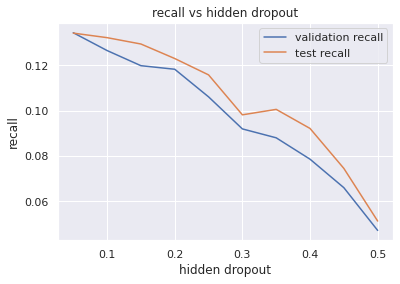

In [ ]:
#hidden dropout plot (bert-base-uncased)

plt.plot(np.arange(0.05,0.55,0.05), [i[0] for i in recall_tuples], label='validation recall')
plt.plot(np.arange(0.05,0.55,0.05), [i[1] for i in recall_tuples], label='test recall')
plt.xlabel('hidden dropout')
plt.ylabel('recall')
plt.title('recall vs hidden dropout')
plt.legend()
plt.show()

In [ ]:
#attention layer dropout recalls (bert-base-uncased)

attn_recall_tuples = []

for i in np.arange(0.05,0.55,0.05):
  print(i)
  attn_recall_tuples.append(minimodel(attention_probs_dropout_prob=i))

0.05


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

0.1


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

0.15000000000000002


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

0.2


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

0.25


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

0.3


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

0.35000000000000003


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

0.4


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

0.45


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

0.5


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

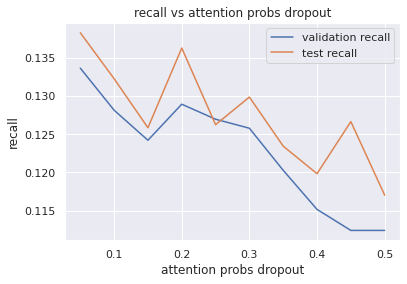

In [ ]:
#attention layer dropout plot (bert-base-uncased)

plt.plot(np.arange(0.05,0.55,0.05), [i[0] for i in attn_recall_tuples], label='validation recall')
plt.plot(np.arange(0.05,0.55,0.05), [i[1] for i in attn_recall_tuples], label='test recall')
plt.xlabel('attention probs dropout')
plt.ylabel('recall')
plt.title('recall vs attention probs dropout')
plt.legend()
plt.show()

In [ ]:
#activation function recalls (bert-base-uncased)

hidden_act_recall_tuples = []

for i in ['gelu','gelu_new','relu','swish']:
  print(i)
  hidden_act_recall_tuples.append(minimodel(hidden_act=i))

gelu


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

gelu_new


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

relu


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

swish


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

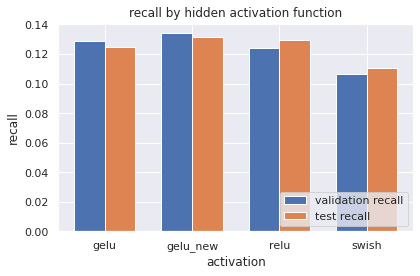

In [ ]:
#activation function plot (bert-base-uncased)

activations = ['gelu','gelu_new','relu','swish']

x = np.arange(len(activations)) 
width = 0.35

plt.bar(x - width/2, [i[0] for i in hidden_act_recall_tuples], width, label='validation recall')
plt.bar(x + width/2, [i[1] for i in hidden_act_recall_tuples], width, label='test recall')

plt.ylabel('recall')
plt.xlabel('activation')
plt.title('recall by hidden activation function')
plt.xticks(x, activations)
plt.legend(loc='lower right')

plt.tight_layout()

plt.show()

0.05


Some weights of BertModel were not initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2 and are newly initialized: ['encoder.layer.8.output.dense.weight', 'encoder.layer.11.attention.self.value.bias', 'encoder.layer.7.attention.output.LayerNorm.weight', 'encoder.layer.7.attention.output.LayerNorm.bias', 'encoder.layer.9.output.LayerNorm.bias', 'encoder.layer.11.attention.output.LayerNorm.bias', 'encoder.layer.9.output.dense.weight', 'encoder.layer.7.attention.self.value.weight', 'encoder.layer.6.attention.output.LayerNorm.weight', 'encoder.layer.6.output.LayerNorm.bias', 'encoder.layer.10.output.dense.weight', 'encoder.layer.8.attention.self.key.weight', 'encoder.layer.6.attention.self.value.bias', 'encoder.layer.8.attention.output.LayerNorm.weight', 'encoder.layer.10.output.LayerNorm.weight', 'encoder.layer.6.attention.self.query.weight', 'encoder.layer.6.attention.output.LayerNorm.bias', 'encoder.layer.8.attention.self.key.bias', 'encoder.layer.6.attention.

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

0.1


Some weights of BertModel were not initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2 and are newly initialized: ['encoder.layer.8.output.dense.weight', 'encoder.layer.11.attention.self.value.bias', 'encoder.layer.7.attention.output.LayerNorm.weight', 'encoder.layer.7.attention.output.LayerNorm.bias', 'encoder.layer.9.output.LayerNorm.bias', 'encoder.layer.11.attention.output.LayerNorm.bias', 'encoder.layer.9.output.dense.weight', 'encoder.layer.7.attention.self.value.weight', 'encoder.layer.6.attention.output.LayerNorm.weight', 'encoder.layer.6.output.LayerNorm.bias', 'encoder.layer.10.output.dense.weight', 'encoder.layer.8.attention.self.key.weight', 'encoder.layer.6.attention.self.value.bias', 'encoder.layer.8.attention.output.LayerNorm.weight', 'encoder.layer.10.output.LayerNorm.weight', 'encoder.layer.6.attention.self.query.weight', 'encoder.layer.6.attention.output.LayerNorm.bias', 'encoder.layer.8.attention.self.key.bias', 'encoder.layer.6.attention.

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

0.15000000000000002


Some weights of BertModel were not initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2 and are newly initialized: ['encoder.layer.8.output.dense.weight', 'encoder.layer.11.attention.self.value.bias', 'encoder.layer.7.attention.output.LayerNorm.weight', 'encoder.layer.7.attention.output.LayerNorm.bias', 'encoder.layer.9.output.LayerNorm.bias', 'encoder.layer.11.attention.output.LayerNorm.bias', 'encoder.layer.9.output.dense.weight', 'encoder.layer.7.attention.self.value.weight', 'encoder.layer.6.attention.output.LayerNorm.weight', 'encoder.layer.6.output.LayerNorm.bias', 'encoder.layer.10.output.dense.weight', 'encoder.layer.8.attention.self.key.weight', 'encoder.layer.6.attention.self.value.bias', 'encoder.layer.8.attention.output.LayerNorm.weight', 'encoder.layer.10.output.LayerNorm.weight', 'encoder.layer.6.attention.self.query.weight', 'encoder.layer.6.attention.output.LayerNorm.bias', 'encoder.layer.8.attention.self.key.bias', 'encoder.layer.6.attention.

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

0.2


Some weights of BertModel were not initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2 and are newly initialized: ['encoder.layer.8.output.dense.weight', 'encoder.layer.11.attention.self.value.bias', 'encoder.layer.7.attention.output.LayerNorm.weight', 'encoder.layer.7.attention.output.LayerNorm.bias', 'encoder.layer.9.output.LayerNorm.bias', 'encoder.layer.11.attention.output.LayerNorm.bias', 'encoder.layer.9.output.dense.weight', 'encoder.layer.7.attention.self.value.weight', 'encoder.layer.6.attention.output.LayerNorm.weight', 'encoder.layer.6.output.LayerNorm.bias', 'encoder.layer.10.output.dense.weight', 'encoder.layer.8.attention.self.key.weight', 'encoder.layer.6.attention.self.value.bias', 'encoder.layer.8.attention.output.LayerNorm.weight', 'encoder.layer.10.output.LayerNorm.weight', 'encoder.layer.6.attention.self.query.weight', 'encoder.layer.6.attention.output.LayerNorm.bias', 'encoder.layer.8.attention.self.key.bias', 'encoder.layer.6.attention.

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

0.25


Some weights of BertModel were not initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2 and are newly initialized: ['encoder.layer.8.output.dense.weight', 'encoder.layer.11.attention.self.value.bias', 'encoder.layer.7.attention.output.LayerNorm.weight', 'encoder.layer.7.attention.output.LayerNorm.bias', 'encoder.layer.9.output.LayerNorm.bias', 'encoder.layer.11.attention.output.LayerNorm.bias', 'encoder.layer.9.output.dense.weight', 'encoder.layer.7.attention.self.value.weight', 'encoder.layer.6.attention.output.LayerNorm.weight', 'encoder.layer.6.output.LayerNorm.bias', 'encoder.layer.10.output.dense.weight', 'encoder.layer.8.attention.self.key.weight', 'encoder.layer.6.attention.self.value.bias', 'encoder.layer.8.attention.output.LayerNorm.weight', 'encoder.layer.10.output.LayerNorm.weight', 'encoder.layer.6.attention.self.query.weight', 'encoder.layer.6.attention.output.LayerNorm.bias', 'encoder.layer.8.attention.self.key.bias', 'encoder.layer.6.attention.

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

0.3


Some weights of BertModel were not initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2 and are newly initialized: ['encoder.layer.8.output.dense.weight', 'encoder.layer.11.attention.self.value.bias', 'encoder.layer.7.attention.output.LayerNorm.weight', 'encoder.layer.7.attention.output.LayerNorm.bias', 'encoder.layer.9.output.LayerNorm.bias', 'encoder.layer.11.attention.output.LayerNorm.bias', 'encoder.layer.9.output.dense.weight', 'encoder.layer.7.attention.self.value.weight', 'encoder.layer.6.attention.output.LayerNorm.weight', 'encoder.layer.6.output.LayerNorm.bias', 'encoder.layer.10.output.dense.weight', 'encoder.layer.8.attention.self.key.weight', 'encoder.layer.6.attention.self.value.bias', 'encoder.layer.8.attention.output.LayerNorm.weight', 'encoder.layer.10.output.LayerNorm.weight', 'encoder.layer.6.attention.self.query.weight', 'encoder.layer.6.attention.output.LayerNorm.bias', 'encoder.layer.8.attention.self.key.bias', 'encoder.layer.6.attention.

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

0.35000000000000003


Some weights of BertModel were not initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2 and are newly initialized: ['encoder.layer.8.output.dense.weight', 'encoder.layer.11.attention.self.value.bias', 'encoder.layer.7.attention.output.LayerNorm.weight', 'encoder.layer.7.attention.output.LayerNorm.bias', 'encoder.layer.9.output.LayerNorm.bias', 'encoder.layer.11.attention.output.LayerNorm.bias', 'encoder.layer.9.output.dense.weight', 'encoder.layer.7.attention.self.value.weight', 'encoder.layer.6.attention.output.LayerNorm.weight', 'encoder.layer.6.output.LayerNorm.bias', 'encoder.layer.10.output.dense.weight', 'encoder.layer.8.attention.self.key.weight', 'encoder.layer.6.attention.self.value.bias', 'encoder.layer.8.attention.output.LayerNorm.weight', 'encoder.layer.10.output.LayerNorm.weight', 'encoder.layer.6.attention.self.query.weight', 'encoder.layer.6.attention.output.LayerNorm.bias', 'encoder.layer.8.attention.self.key.bias', 'encoder.layer.6.attention.

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

0.4


Some weights of BertModel were not initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2 and are newly initialized: ['encoder.layer.8.output.dense.weight', 'encoder.layer.11.attention.self.value.bias', 'encoder.layer.7.attention.output.LayerNorm.weight', 'encoder.layer.7.attention.output.LayerNorm.bias', 'encoder.layer.9.output.LayerNorm.bias', 'encoder.layer.11.attention.output.LayerNorm.bias', 'encoder.layer.9.output.dense.weight', 'encoder.layer.7.attention.self.value.weight', 'encoder.layer.6.attention.output.LayerNorm.weight', 'encoder.layer.6.output.LayerNorm.bias', 'encoder.layer.10.output.dense.weight', 'encoder.layer.8.attention.self.key.weight', 'encoder.layer.6.attention.self.value.bias', 'encoder.layer.8.attention.output.LayerNorm.weight', 'encoder.layer.10.output.LayerNorm.weight', 'encoder.layer.6.attention.self.query.weight', 'encoder.layer.6.attention.output.LayerNorm.bias', 'encoder.layer.8.attention.self.key.bias', 'encoder.layer.6.attention.

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

0.45


Some weights of BertModel were not initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2 and are newly initialized: ['encoder.layer.8.output.dense.weight', 'encoder.layer.11.attention.self.value.bias', 'encoder.layer.7.attention.output.LayerNorm.weight', 'encoder.layer.7.attention.output.LayerNorm.bias', 'encoder.layer.9.output.LayerNorm.bias', 'encoder.layer.11.attention.output.LayerNorm.bias', 'encoder.layer.9.output.dense.weight', 'encoder.layer.7.attention.self.value.weight', 'encoder.layer.6.attention.output.LayerNorm.weight', 'encoder.layer.6.output.LayerNorm.bias', 'encoder.layer.10.output.dense.weight', 'encoder.layer.8.attention.self.key.weight', 'encoder.layer.6.attention.self.value.bias', 'encoder.layer.8.attention.output.LayerNorm.weight', 'encoder.layer.10.output.LayerNorm.weight', 'encoder.layer.6.attention.self.query.weight', 'encoder.layer.6.attention.output.LayerNorm.bias', 'encoder.layer.8.attention.self.key.bias', 'encoder.layer.6.attention.

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

0.5


Some weights of BertModel were not initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2 and are newly initialized: ['encoder.layer.8.output.dense.weight', 'encoder.layer.11.attention.self.value.bias', 'encoder.layer.7.attention.output.LayerNorm.weight', 'encoder.layer.7.attention.output.LayerNorm.bias', 'encoder.layer.9.output.LayerNorm.bias', 'encoder.layer.11.attention.output.LayerNorm.bias', 'encoder.layer.9.output.dense.weight', 'encoder.layer.7.attention.self.value.weight', 'encoder.layer.6.attention.output.LayerNorm.weight', 'encoder.layer.6.output.LayerNorm.bias', 'encoder.layer.10.output.dense.weight', 'encoder.layer.8.attention.self.key.weight', 'encoder.layer.6.attention.self.value.bias', 'encoder.layer.8.attention.output.LayerNorm.weight', 'encoder.layer.10.output.LayerNorm.weight', 'encoder.layer.6.attention.self.query.weight', 'encoder.layer.6.attention.output.LayerNorm.bias', 'encoder.layer.8.attention.self.key.bias', 'encoder.layer.6.attention.

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

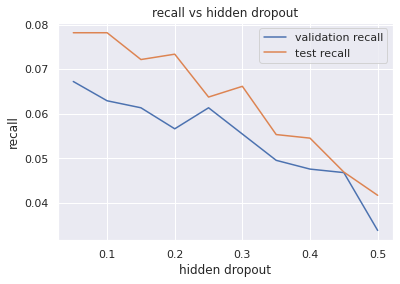

In [ ]:
#hidden layer dropout recalls (sentence-transformers)

recall_tuples2 = []

for i in np.arange(0.05,0.55,0.05):
  print(i)
  recall_tuples2.append(minimodel(hidden_dropout_prob=i, bert_base_uncased=False))

plt.plot(np.arange(0.05,0.55,0.05), [i[0] for i in recall_tuples2], label='validation recall')
plt.plot(np.arange(0.05,0.55,0.05), [i[1] for i in recall_tuples2], label='test recall')
plt.xlabel('hidden dropout')
plt.ylabel('recall')
plt.title('recall vs hidden dropout')
plt.legend()
plt.show()

Cells below were used to test dense layer activation functions.

In [ ]:
#from transformers import AutoConfig

#config = AutoConfig.from_pretrained('bert-base-uncased')
#config

In [ ]:
#try:
#  del model
#except:
#  pass

In [ ]:
#word_embedding_model = models.Transformer('bert-base-uncased', max_seq_length=256, model_args={'hidden_dropout_prob':0.1, 'attention_probs_dropout_prob':0.1, 'hidden_act':'gelu_new'})
#pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
#dense_model = models.Dense(in_features=word_embedding_model.get_word_embedding_dimension(), out_features=256, activation_function=nn.ReLU())


#model = SentenceTransformer(modules=[word_embedding_model, pooling_model, dense_model])

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
#train_loss = losses.MultipleNegativesRankingLoss(model)

In [ ]:
#torch.cuda.empty_cache()
#pool = model.start_multi_process_pool('cuda')
#model.fit(train_objectives=[(mini_train_dataloader, train_loss)], epochs=5, warmup_steps=100) 

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

Iteration:   0%|          | 0/394 [00:00<?, ?it/s]

In [ ]:
#TAE = []
#for i in range(len(minitrain_answers)):
#  print(i)
#  TAE.append(model.encode(minitrain_answers[i]))
  
#VCE = [model.encode(i) for i in minival_clues]
#TCE = [model.encode(i) for i in minitest_clues]
#VCEF = [model.encode(i) for i in miniFval_clues]
#TCEF = [model.encode(i) for i in miniFtest_clues]

Streaming output truncated to the last 5000 lines.
14697
14698
14699
14700
14701
14702
14703
14704
14705
14706
14707
14708
14709
14710
14711
14712
14713
14714
14715
14716
14717
14718
14719
14720
14721
14722
14723
14724
14725
14726
14727
14728
14729
14730
14731
14732
14733
14734
14735
14736
14737
14738
14739
14740
14741
14742
14743
14744
14745
14746
14747
14748
14749
14750
14751
14752
14753
14754
14755
14756
14757
14758
14759
14760
14761
14762
14763
14764
14765
14766
14767
14768
14769
14770
14771
14772
14773
14774
14775
14776
14777
14778
14779
14780
14781
14782
14783
14784
14785
14786
14787
14788
14789
14790
14791
14792
14793
14794
14795
14796
14797
14798
14799
14800
14801
14802
14803
14804
14805
14806
14807
14808
14809
14810
14811
14812
14813
14814
14815
14816
14817
14818
14819
14820
14821
14822
14823
14824
14825
14826
14827
14828
14829
14830
14831
14832
14833
14834
14835
14836
14837
14838
14839
14840
14841
14842
14843
14844
14845
14846
14847
14848
14849
14850
14851
14852
14853
14854
1

In [ ]:
#quantizer = faiss.IndexFlatL2(len(VCE[0]))
#index = faiss.IndexIVFFlat(quantizer, len(VCE[0]), 5)
#index.train(np.array(TAE))
#index.add(np.array(TAE))
#minival_D, minival_I = index.search(np.array(VCE), 25)
#minitest_D, minitest_I = index.search(np.array(TCE), 25)
#minivalF_D, minivalF_I = index.search(np.array(VCEF), 25)
#minitestF_D, minitestF_I = index.search(np.array(TCEF), 25)

In [ ]:
#np.mean([bool(minival_answers[i] in minitrain_answers[minival_I[i]]) for i in range(len(minival_answers))])

0.13168238993710693

In [ ]:
#np.mean([bool(minitest_answers[i] in minitrain_answers[minitest_I[i]]) for i in range(len(minitest_answers))])

0.13787575150300602

In [ ]:
#np.mean([bool(miniFval_answers[i] in minitrain_answers[minivalF_I[i]]) for i in range(len(miniFval_answers))])

0.24257784214337436

In [ ]:
#np.mean([bool(miniFtest_answers[i] in minitrain_answers[minitestF_I[i]]) for i in range(len(miniFtest_answers))])

0.24431818181818182